## Einrichtung von Julia JuMP
---
Überprüfen Sie die bereits installierten Pakete. In der JuliaBox sind möglicherweise alle notwendigen Pakete bereits vorhanden.

In [24]:
using Pkg;
Pkg.status()

Status `C:\Users\krueg\.julia\environments\JuliaPro_v1.5.3-1\Project.toml`
  [c52e3926] Atom v0.12.25 ⚲
  [9961bab8] Cbc v0.7.1
  [e2554f3b] Clp v0.8.3
  [a93c6f00] DataFrames v0.22.1
  [7073ff75] IJulia v1.22.0
  [4076af6c] JuMP v0.21.5
  [e5e0dc1b] Juno v0.8.4 ⚲
  [4722fa14] PkgAuthentication v0.3.0
  [f3b207a7] StatsPlots v0.14.17
  [44d3d7a6] Weave v0.10.6


Installieren Sie ``JuMP`` , mit dem Sie einfach Optimierungsprogramme formulieren können, sowie ``Cbc``, einen open-source Solver zum Lösen des Problems, und ``StatsPlots`` zur Visualisierung der Lösung.

In [25]:
#Pkg.add("JuMP");
#Pkg.add("Cbc");
#Pkg.add("StatsPlots");

Richten Sie die installierten Pakete so ein, dass sie im folgenden Code verwendet werden können.

In [26]:
using JuMP, Cbc, StatsPlots;

# Capacitated Lot Sizing Problem

### Entscheidungsvariablen:
Bestimmung der **Produktionsmengen** und **Lagerbestände** je Periode sowie der daraus folgenden **Rüstvorgänge**,

### Zielfunktion:
0) **Gesamtkostenminimierung:** $$ \qquad \min z = \displaystyle\sum_{i=1}^I \displaystyle\sum_{t=1}^T(k_i^s\cdot \gamma_{it}+k_i^l\cdot L_{it})$$ 

### Nebenbedingungen:
1) **Kapazitaetsrestriktion:**  $ \hspace{40mm} \displaystyle\sum_{i=1}^I(t_i^p\cdot X_{it}+t_i^s\cdot\gamma_{it} ) \leq c_t \hspace{40mm} \forall t \in T\qquad $ 

2) **Lagerbilanzgleichung:**  $ \hspace{41mm} L_{it} = L_{i,t-1}+X_{it}-d_{it} \hspace{44mm} \forall t \in T, \quad i \in I$

3) **Anfangslagerbestand:** $ \hspace{41mm} L_{i,0} = l_{start} \hspace{66mm} \forall  i \in I$

4) **Rüstbedingung:**:  $ \hspace{50mm} X_{it} \leq M \cdot \gamma_{it} \hspace{63mm} \forall t \in T, \quad i \in I $

5) **Nichtnegativitaetsbedingungen:**  $ \hspace{23mm} X_{it}, L_{it} \geq 0  \hspace{66mm} \forall t \in T, \quad i \in I $

6) **Binaerbedingung:** 
 $ \hspace{48mm}  \gamma_{it} \in \{0,1\}  \hspace{67mm} \forall t \in T, \quad i \in I $
* * *

## Verwendete Symbole

### Mengen

$i \in (1,..,I) \hspace{20mm}$ Produkte
 
$t \in (1,..,T) \hspace{20mm}$ Perioden 


### Parameter

$k_i^l \hspace{38mm}$ Lagerkostensatz

$k_i^s \hspace{38mm}$  Ruestkostensatz  

$t_i^p \hspace{39mm}$  Produktionszeit 

$t_i^s \hspace{39mm}$  Rüstzeit 

$M \hspace{37mm}$  Große Zahl   

$c_t \hspace{38mm}$  Periodenkapazität 

$b_{it}\hspace{37mm}$ Bedarf 

$l_{start} \hspace{34mm}$  Anfangslagerbestand 


### Variablen

$X_{it}$  $\geq0 \hspace{28mm}$       Produktionsmenge   

$L_{it}$  $\geq0 \hspace{28mm}$      Lagermenge         

$\gamma_{it}$  $\in\{0,1\} \hspace{21mm}$ binäre Rüstvariable        

* * *

## Erstellen Sie das Modell namens ``m`` und geben Sie als zu verwendenden Solver Cbc an.
---

In [27]:
m = Model(Cbc.Optimizer);

### Mengen und Parameter

Fügen Sie die Mengen ein.


In [28]:
#Mengen
Produkte = ["i1", "i2", "i3"];
Perioden = ["t1", "t2", "t3", "t4"];
#Längen
I = length(Produkte);
T = length(Perioden);


Fügen Sie die Parameter ein.

In [29]:
kl = [4, 6, 5];                 #Lagerkostensatz der Produkte

ks = [80, 100, 90];             #Rüstkostensatz der Produkte

ts = [8, 12, 16];               #Rüstzeiten der Produkte

tp = [2, 2, 1];                 #Stückbearbeitungszeiten der Produkte

c =  [320, 320, 320, 320]; #Periodenkapazität

M = 1000;                       #Große Zahl

l_start = [0, 0, 0];            #Anfangslagerbestand

      #t1, t2, t3, t4
b = [  50  10  10  140          #Produkt 1
        0  40  80   30          #Produkt 2
       90  80  10   50];        #Produkt 3

                                #Bedarf

### Entscheidungsvariablen
---
Definieren Sie die Entscheidungsvariablen. Achten Sie auf die Definitionsbereiche (Nebenbedingungen 5 und 6)

5) **Nichtnegativitätsbedingungen**: Produktionsmengen und Lagerbestände dürfen nicht negativ werden.

 $ \qquad X_{it}, L_{it} \geq 0  \qquad\qquad\qquad\qquad\qquad\qquad \forall t \in T, \quad i \in I $

In [30]:
@variable(m,X[1:I,1:T] >= 0,Int);  #Produktionsmenge von Produkt i in Periode t

In [31]:
@variable(m,L[1:I,0:T] >= 0,Int);  #Lagerbestand von Produkt i am Periodenende von t

6) **Binaerbedingung**: Rüstvorgänge werden immer ganz ($\gamma_{it} = 1$) oder gar nicht ($\gamma_{it} = 0$) ausgeführt. Die binäre Rüstvariable nimmt also entweder den Wert 1 oder 0 an.

 $ \qquad  \gamma_{it} \in \{0,1\}  \qquad\qquad\qquad\qquad\qquad\qquad \forall t \in T, \quad i \in I $

In [32]:
@variable(m,gamma[1:I,1:T],Bin); #Die binäre Rüstvariable von Produkt i in Periode t

## Zielfunktion

0) **Gesamtkostenminimierung:** Die Gesamtkosten sollen minimiert werden. Sie bestehen aus der Summe von Rüstkosten und Lagerkosten aller Produkte über alle Perioden. Die Rüstkosten berechnen sich hierbei durch Multipizieren der Anzahl der Rüstvorgänge (Summe aler binären Rüstvariablen) mit dem Rüstkostensatz, die Lagerkosten durch Multiplizieren der eingelagerten Menge mit dem Lagerkostensatz.

$ \qquad \min z = \displaystyle\sum_{i=1}^I \displaystyle\sum_{t=1}^T(k_i^s\cdot \gamma_{it}+k_i^l\cdot L_{it})$ 


In [33]:
@objective(m, Min,  sum( ks[i] * gamma[i,t] +  kl[i] * L[i,t]  for i=1:I for t=1:T) );

## Nebenbedingungen

1) **Kapazitaetsrestriktion:** Die Summe aus Produktions- und Rüstzeit aller Produkte darf in jeder Periode die vorhandene Kapazität der Ressource j nicht überschreiten.

 $$ \qquad \displaystyle\sum_{i=1}^I(t_i^p\cdot X_{it}+t_i^s\cdot\gamma_{it} ) \leq c_t \hspace{40mm} \forall t \in T\qquad $$ 
 


In [34]:
@constraint(m, KapRes[t=1:T], sum((ts[i] * gamma[i,t] + tp[i] * X[i,t]) for i=1:I) <= c[t] );

2) **Lagerbilanzgleichung**: Der Lagerbestand am Ende einer Periode berechnet sich aus der Summe der Produktionsmenge und des Lagerbestandes der Vorperiode abzüglich der Absatzmenge (Nachfrage).

 $$ \qquad L_{it} = L_{i,t-1}+X_{it}-b_{it} \hspace{40mm} \forall t \in T, \quad i \in I$$

In [35]:
@constraint(m, Lager[i=1:I,t=1:T], L[i,t] == L[i,t-1] + X[i,t]  - b[i,t]);

 3) **Anfangslagerbestand**: Der Anfangslagerbestand aller Produkte entspricht dem initial gesetzen $l_i$.
 
  $$ \qquad L_{i,0} = l_{start} \hspace{40mm} \forall  i \in I$$


In [36]:
@constraint(m, AnfLager[i=1:I], L[i,0] == l_start[i]);

4) **Rüstbedingung**: Wenn für ein Produkt in einer Periode nicht gerüstet wird, ist die produzierte Menge dieses Produkts in dieser Periode 0. Wenn für ein Produkt in einer Periode gerüstet wird, wird die produzierte Menge durch die Rüstbedingung nicht eingeschränkt.

 $$ \qquad X_{it} \leq M \cdot \gamma_{it} \hspace{40mm} \forall t \in T, \quad i \in I $$

In [37]:
@constraint(m, Ruestbed[i=1:I,t=1:T], X[i,t] <= M * gamma[i,t]);

## Lösen Sie das Modell.
---

In [38]:
optimize!(m)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Jan  1 1970 

command line - Cbc_C_Interface -solve -quit (default strategy 1)
Continuous objective value is 196.484 - 0.00 seconds
Cgl0003I 0 fixed, 36 tightened bounds, 10 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 17 tightened bounds, 0 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 2 tightened bounds, 0 strengthened rows, 0 substitutions
Cgl0004I processed model has 23 rows, 31 columns (31 integer (10 of which binary)) and 70 elements
Cbc0012I Integer solution of 1390 found by DiveCoefficient after 0 iterations and 0 nodes (0.02 seconds)
Cbc0038I Full problem 23 rows 31 columns, reduced to 12 rows 15 columns
Cbc0012I Integer solution of 1048 found by DiveCoefficient after 16 iterations and 0 nodes (0.03 seconds)
Cbc0031I 10 added rows had average density of 4.5
Cbc0013I At root node, 10 cuts changed objective from 553.01535 to 1048 in 4 passes
Cbc0014I Cut generator 0 (Probing) - 18 row cuts average 2.3 el

Lassen Sie sich den Zielfunktionswert Z anzeigen.

In [39]:
println("Objective value Z: ", JuMP.objective_value(m))

Objective value Z: 1048.0


Lassen Sie sich die Produktionsmengen, die Lagermengen und die Rüstvariable anzeigen.

In [40]:
JuMP.value.(X)

3×4 Array{Float64,2}:
 60.0   0.0   27.0  123.0
  0.0  40.0  110.0    0.0
 90.0  90.0    0.0   50.0

In [41]:
JuMP.value.(L)

2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, Base.OneTo(3)
    Dimension 2, 0:4
And data, a 3×5 Array{Float64,2}:
 0.0  10.0   0.0  17.0  0.0
 0.0   0.0   0.0  30.0  0.0
 0.0   0.0  10.0   0.0  0.0

In [42]:
JuMP.value.(gamma)

3×4 Array{Float64,2}:
 1.0  0.0  1.0  1.0
 0.0  1.0  1.0  0.0
 1.0  1.0  0.0  1.0

Stellen Sie Produktionsmenge, Nachfrage und Lagerbestand grafisch dar.

In [43]:
bardata = zeros((4,3,I))
for i in 1:I
    bardata[:,:,i] = 
    [JuMP.value(X[i,1]) b[i,1] JuMP.value(L[i,1])
     JuMP.value(X[i,2]) b[i,2] JuMP.value(L[i,2])
     JuMP.value(X[i,3]) b[i,3] JuMP.value(L[i,3])
     JuMP.value(X[i,4]) b[i,4] JuMP.value(L[i,4])]
end

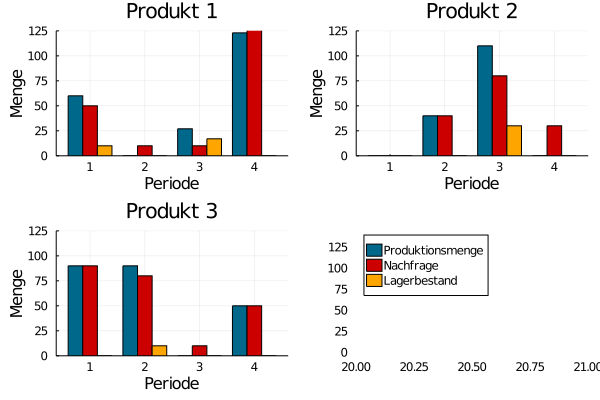

In [44]:
p1 = groupedbar(bardata[:,:,1], label=["Produktionsmenge" "Nachfrage" "Lagerbestand"],legend=:none, 
                colour = [:DeepSkyBlue4 :Red3 :orange], title = "Produkt 1", xlabel = "Periode", 
                ylabel="Menge", ylim=(0, 125))
p2 = groupedbar(bardata[:,:,2], label=["Produktionsmenge" "Nachfrage" "Lagerbestand"], legend=:none,
                colour = [:DeepSkyBlue4 :Red3 :orange], title = "Produkt 2", xlabel = "Periode", 
                ylabel="Menge", ylim=(0, 125))
p3 = groupedbar(bardata[:,:,3], label=["Produktionsmenge" "Nachfrage" "Lagerbestand"], legend=:none,
                colour = [:DeepSkyBlue4 :Red3 :orange], title = "Produkt 3", xlabel = "Periode", 
                ylabel="Menge", ylim=(0, 125))
p4 = groupedbar(bardata[:,:,1,1], label=["Produktionsmenge" "Nachfrage" "Lagerbestand"],legend=:topleft,
                colour = [:DeepSkyBlue4 :Red3 :orange], grid=false, xlims=(20,3), showaxis=false)
plot(p1, p2, p3, p4, layout = 4)


Stellen Sie die Rüstvariable für die drei Produkte grafisch dar.

In [45]:
bardataGamma = [JuMP.value(gamma[i,t]) for i in 1:I, t in 1:T]'

4×3 LinearAlgebra.Adjoint{Float64,Array{Float64,2}}:
 1.0  0.0  1.0
 0.0  1.0  1.0
 1.0  1.0  0.0
 1.0  0.0  1.0

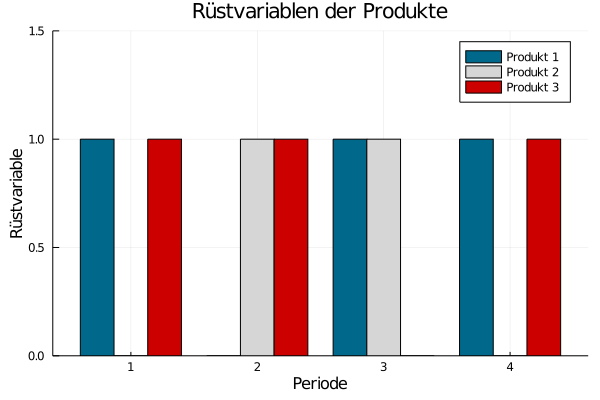

In [46]:
groupedbar(bardataGamma, label=["Produkt 1" "Produkt 2" "Produkt 3"], xlabel = "Periode",
           ylabel = "Rüstvariable", title = "Rüstvariablen der Produkte",
           colour = [:DeepSkyBlue4 :grey84 :Red3], ylim = (0,1.5))
